# Validate mapping of PalmDB nucleotides to amino acid reference

In [1]:
from Bio import SeqIO
import pandas as pd
import numpy as np
from itertools import product
import kb_python.utils as kb_utils
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
from tqdm import tqdm
TQDM_BAR_FORMAT = (
    "{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]"
)

In [2]:
virus_index = f"/home/laura/projects/virus-watch-data/virus_ref/testing/index_noduplicates.idx"
virus_t2g = "/home/laura/projects/virus-watch-data/virus_ref/nodup_clu_t2g.txt"
u_tax_dp = "/home/laura/projects/virus-watch-data/virus_ref/u_tax_nodup_clu.csv"

kallisto = "/home/laura/projects/kallisto/build/src/kallisto"
bustools = "/home/laura/projects/bustools/build/src/bustools"

palmdb = "/home/laura/projects/virus-watch-data/virus_ref/uniques_noduplicates.fa"
# Also generated in 3.4_check_detection_of_orig_seqs_all-vs-all.ipynb in virus_index
palmdb_nn_fasta = "/home/laura/projects/virus-watch-data/virus_ref/testing/uniques_nn.fasta"

palmdb_nn_R1 = "/home/laura/projects/virus-watch-data/virus_ref/testing/uniques_nn_barcodes_R1.fasta"
out_folder = "/home/laura/projects/virus-watch-data/virus_ref/testing/palmdb_mapping_validation"

Reverse translate virus ref amino acid sequences to nucleotides:

In [9]:
# Adapted from https://github.com/Edinburgh-Genome-Foundry/DnaChisel
from Bio.Data import CodonTable

def flatten(l):
    return [item for sublist in l for item in sublist]

def get_backtranslation_table(table_name="Standard"):
    table = CodonTable.unambiguous_dna_by_name[table_name]
    back_translation_table = {}
    for codon, amino_acid in table.forward_table.items():
        if amino_acid not in back_translation_table:
            back_translation_table[amino_acid] = []
        back_translation_table[amino_acid].append(codon)
    back_translation_table["*"] = table.stop_codons
    back_translation_table["START"] = table.start_codons
    back_translation_table["X"] = list(set(flatten(back_translation_table.values())) - set(back_translation_table["*"]))
    back_translation_table["B"] = back_translation_table["N"] + back_translation_table["D"]
    back_translation_table["J"] = back_translation_table["L"] + back_translation_table["I"]
    back_translation_table["Z"] = back_translation_table["E"] + back_translation_table["Q"]
    return back_translation_table

def reverse_translate(protein_sequence, randomize_codons=False, table="Standard"):
    """Return a DNA sequence which translates to the provided protein sequence.

    Parameters
    ----------

    protein_sequence
      A sequence string of aminoacids, e.g. "MVKK..."

    table
      Genetic code table to use (e.g. 'Standard', 'Bacterial', etc.).
      See dnachisel.biotools.CODON_TABLE_NAMES for a list of available genetic
      code tables.

    randomize_codons
      If False, the first valid codon found is used for each, which can create
      biases (GC content, etc.), if True, each amino acid gets replaced by a
      randomly selected codon for this amino acid.
    """
    backtranslation_table = get_backtranslation_table(table_name=table)
    if randomize_codons:
        random_numbers = np.random.randint(0, 1000, len(protein_sequence))
        random_indices = [
            random_number % len(backtranslation_table[aa])
            for aa, random_number in zip(protein_sequence, random_numbers)
        ]
        return "".join(
            [
                backtranslation_table[aa][random_indice]
                for aa, random_indice in zip(protein_sequence, random_indices)
            ]
        )
    return "".join([backtranslation_table[aa][0] for aa in protein_sequence])

In [12]:
# Reverse translate virus ref amino acid sequences to nucleotides and save to fasta
from Bio import SeqIO

with open(palmdb) as handle, open(palmdb_nn_fasta, "w") as palm_nuc:
    for record in SeqIO.parse(handle, "fasta"):
        palm_nuc.write(">" + str(record.id) + "\n")
        palm_nuc.write(reverse_translate(str(record.seq), table="Standard") + "\n")

Create fake R1 file with barcodes for rev translated PalmDB:

In [14]:
# Create a fake barcode for each sequence in the PalmDB
barcodes = [''.join(i) for i in product(["A", "C", "G", "T"], repeat=10)]

print(len(barcodes))
barcodes[:10]

1048576


['AAAAAAAAAA',
 'AAAAAAAAAC',
 'AAAAAAAAAG',
 'AAAAAAAAAT',
 'AAAAAAAACA',
 'AAAAAAAACC',
 'AAAAAAAACG',
 'AAAAAAAACT',
 'AAAAAAAAGA',
 'AAAAAAAAGC']

In [15]:
# Create fake R1 file with barcodes
virus_ids = []
with open(palmdb_nn_R1, "w") as fake_R1:
    for (barcode, record) in zip(barcodes[:296561], SeqIO.parse(palmdb_nn_fasta, "fasta")):
        fake_R1.write(">" + record.id + "\n")
        fake_R1.write(barcode + "\n")
        virus_ids.append(record.id)

In [16]:
len(virus_ids)

296561

In [17]:
bc2virus = pd.DataFrame()
bc2virus["virus_ID"] = virus_ids
bc2virus["barcode"] = barcodes[:296561]
bc2virus.head()

,virus_ID,barcode
0,u1,AAAAAAAAAA
1,u2,AAAAAAAAAC
2,u3,AAAAAAAAAG
3,u4,AAAAAAAAAT
4,u5,AAAAAAAACA


Align:

In [18]:
# Use kallisto to align with fake barcodes
!$kallisto bus \
        -i $virus_index \
        -o $out_folder \
        --aa \
        -x 0,0,0:0,0,10:1,0,0 \
        -t 32 \
        $palmdb_nn_R1 $palmdb_nn_fasta 

!$bustools sort -o $out_folder/output_sorted.bus $out_folder/output.bus

!$bustools count \
    --genecounts \
    --cm \
    -o $out_folder/bustools_count/ \
    -g $virus_t2g \
    -e $out_folder/matrix.ec \
    -t $out_folder/transcripts.txt \
    $out_folder/output_sorted.bus


[bus] Note: Strand option was not specified; setting it to --unstranded for specified technology
[index] k-mer length: 31
[index] number of targets: 296,561
[index] number of k-mers: 37,541,756
[quant] will process sample 1: /home/laura/projects/virus-watch-data/virus_ref/testing/uniques_nn_barcodes_R1.fasta
                               /home/laura/projects/virus-watch-data/virus_ref/testing/uniques_nn.fasta
[quant] finding pseudoalignments for the reads ... done
[quant] processed 296,561 reads, 288,295 reads pseudoaligned

 all fits in buffer
Read in 288295 BUS records
reading time 0s
sorting time 0.02s
writing time 0.01s


In [19]:
# Load data
# Filepath to counts
X = f"{out_folder}/bustools_count/output.mtx"
# Filepath to barcode metadata
var_path = f"{out_folder}/bustools_count/output.genes.txt"
# Filepath to gene metadata
obs_path = f"{out_folder}/bustools_count/output.barcodes.txt" 

# Create AnnData object
adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)

adata

/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:670: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)


AnnData object with n_obs × n_vars = 288295 × 99228

In [20]:
adata.obs

""
barcode
AAAAAAAAAA
AAAAAAAAAC
AAAAAAAAAG
AAAAAAAAAT
AAAAAAAACA
...
CAGACGCGGT
CAGACGCGTA
CAGACGCGTC


In [21]:
# Add virus IDs
adata.obs = adata.obs.merge(bc2virus, how="left", on="barcode", validate="one_to_one").set_index("virus_ID")
adata.obs

,barcode
virus_ID,
u1,AAAAAAAAAA
u2,AAAAAAAAAC
u3,AAAAAAAAAG
u4,AAAAAAAAAT
u5,AAAAAAAACA
...,...
u296618,CAGACGCGGT
u296619,CAGACGCGTA
u296620,CAGACGCGTC


Plot heatmap of ID mapping:

In [22]:
# %%time
# fig, ax = plt.subplots(figsize = (20,20))
# im = ax.imshow(adata.X.todense())
# plt.savefig("figures/palmdb2palmdb_heatmap.png", dpi=300, bbox_inches="tight")

### Plot fraction of each taxa assigned correctly:

In [23]:
tax_df = pd.read_csv(u_tax_dp)
tax_df

,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
...,...,...,...,...,...,...,...,...,...
296556,u296608,u296608,.,.,.,.,.,.,unknown
296557,u296609,u296609,.,.,.,.,.,.,unknown
296558,u296613,u296613,.,.,.,.,.,.,unknown
296559,u296616,u296616,.,.,.,.,.,.,unknown


In [24]:
adata.X.sum()

287160.0

Get fractions of correct/incorrect mapping for each ID for each tax:

In [25]:
def get_acc_fractions(taxon):
    df = pd.DataFrame()
    df["mapping"] = ["correct", "incorrect", "not_aligned", "multimapped"]

    total_n = len(tax_df[taxon].unique()) + 1
    n = 1

    for tax_name in tax_df[taxon].unique():
        correct = 0
        incorrect = 0
        not_aligned = 0
        multimapped = 0

        with tqdm(total=len(tax_df[tax_df[taxon]==tax_name]["ID"].values), bar_format=TQDM_BAR_FORMAT) as pbar:
            pbar.set_description(f"Checking IDs for {tax_name} ({n}/{total_n})")

            for virus_id in tax_df[tax_df[taxon]==tax_name]["ID"].values:
                try:
                    mapping = adata.var[np.array(adata[adata.obs.index == virus_id, :].X.todense())[0] > 0]

                    if len(mapping) == 1:
                        mapped_id = mapping.index[0]

                        if mapped_id == virus_id:
                            correct += 1

                        else:
                            if tax_df[tax_df["ID"]==mapped_id][taxon].values[0] == tax_name:
                                correct += 1

                            else:
                                incorrect += 1

                    else:
                        multimapped += 1

                except IndexError:
                    not_aligned += 1

                pbar.update(1)

        df[tax_name] = [correct, incorrect, not_aligned, multimapped]
        n += 1

    df.to_csv(f"{out_folder}/{taxon}_mapping.csv", index=False)

In [26]:
get_acc_fractions("phylum")

Checking IDs for Uroviricota (10/11): 100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [elapsed: 00:00 remaining: 00:00]


In [27]:
get_acc_fractions("class")

Checking IDs for Milneviricetes (24/25): 100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [elapsed: 00:00 remaining: 00:00]


In [28]:
get_acc_fractions("order")

Checking IDs for Serpentovirales (30/31): 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [elapsed: 00:00 remaining: 00:00]


In [29]:
get_acc_fractions("family")

Checking IDs for Nanhypoviridae (86/87): 100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [elapsed: 00:00 remaining: 00:00]


In [30]:
get_acc_fractions("genus")

Checking IDs for Novirhabdovirus (100/300): 100%|███████████████████████████████████████████████████████████████████████████| 33/33 [elapsed: 00:01 remaining: 00:00]
/tmp/ipykernel_225242/465764441.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tax_name] = [correct, incorrect, not_aligned, multimapped]
Checking IDs for Barnavirus (101/300): 100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [elapsed: 00:00 remaining: 00:00]
/tmp/ipykernel_225242/465764441.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [31]:
get_acc_fractions("species")

Checking IDs for Severe acute respiratory syndrome-related coronavirus (1/1749): 100%|████████████████████████████████████| 409/409 [elapsed: 00:12 remaining: 00:00]
Checking IDs for Human coronavirus HKU1 (7/1749): 100%|███████████████████████████████████████████████████████████████████████| 5/5 [elapsed: 00:00 remaining: 00:00]
Checking IDs for Homalodisca coagulata virus 1 (8/1749): 100%|████████████████████████████████████████████████████████████████| 1/1 [elapsed: 00:00 remaining: 00:00]
Checking IDs for Maize Iranian mosaic nucleorhabdovirus (9/1749): 100%|███████████████████████████████████████████████████████| 1/1 [elapsed: 00:00 remaining: 00:00]
Checking IDs for Mammalian 2 orthobornavirus (10/1749): 100%|█████████████████████████████████████████████████████████████████| 1/1 [elapsed: 00:00 remaining: 00:00]
Checking IDs for Beet necrotic yellow vein virus (11/1749): 100%|█████████████████████████████████████████████████████████████| 1/1 [elapsed: 00:00 remaining: 00:00]
Chec

#### Plot:

In [4]:
def fractions(df):
    m_types = df["mapping"].values
    
    # # Drop unknown virus sequences and transpose dataframe
    # df_T = df.drop(".", axis=1).set_index("mapping").T
    # Transpose dataframe
    df_T = df.set_index("mapping").T
    
    # Add total
    df_T["total"] = df_T.sum(axis=1).values
    
    # Compute fraction of total count for each mapping type
    for mt in m_types:
        df_T[f"{mt}_fraction"] = (df_T[mt] / df_T["total"]).values

    return df_T

/tmp/ipykernel_233840/1738471711.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha="right")
/tmp/ipykernel_233840/1738471711.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha="right")
/tmp/ipykernel_233840/1738471711.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45, ha="right")
/tmp/ipykernel_233840/1738471711.py:185: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax3.get_shared_y_axes().join(axs[0], axs[1], axs[2], axs[3], axs[4])


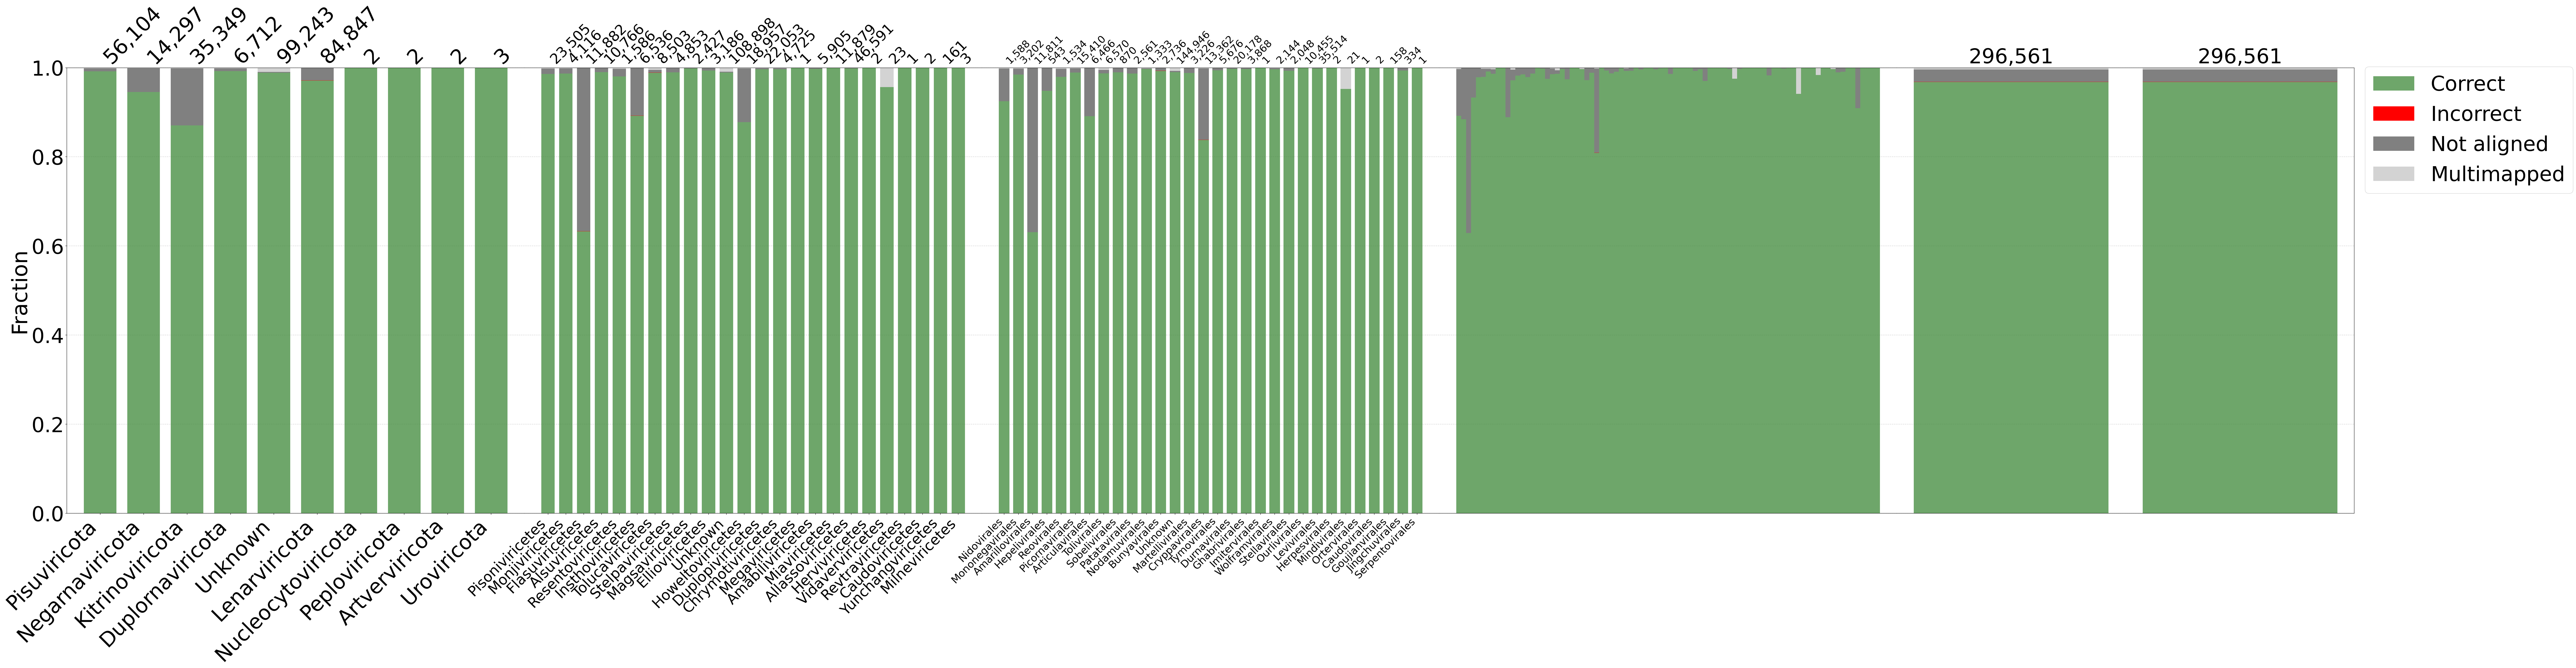

In [18]:
fig, axs = plt.subplots(figsize=(100, 20), ncols=5)

fontsize = 50
subplt_spacing = 0.04

colors = ["#3e8938", "red", "grey", "lightgrey"]
alphas = [0.75, 1, 1, 1]
m_types = ["correct", "incorrect", "not_aligned", "multimapped"]
legend_labels = ["Correct", "Incorrect", "Not aligned", "Multimapped"]

## Plot phylum fractions
phyla_df = pd.read_csv(f"{out_folder}/phylum_mapping.csv")
frac_df = fractions(phyla_df)
x = list(map(lambda st: str.replace(st, ".", "Unknown"), frac_df.index.values))
ax = axs[0]

previous_samples = 0
for alpha, color, mt in zip(alphas, colors, m_types):
    y = frac_df[f"{mt}_fraction"].values
    ax.bar(
        x,
        y,
        width = 0.75,
        bottom = previous_samples,
        color = color,
        alpha = alpha,
    )
    previous_samples = previous_samples + y

# Add number of sequences above each bar
for index, total in enumerate(frac_df["total"].values):
    ax.text(x=index, y=1.01, s="{:,}".format(total), size=fontsize, ha="left", rotation=45)
    
ax.set_xticklabels(x, rotation=45, ha="right")
ax.tick_params(axis="both", labelsize=fontsize)
ax.margins(x=subplt_spacing, y=0)
ax.spines[['right']].set_visible(False)
ax.patch.set_alpha(0)

ax.set_ylabel("Fraction", fontsize=fontsize+2)


## Plot class fractions
class_df = pd.read_csv(f"{out_folder}/class_mapping.csv")
frac_df = fractions(class_df)
x = list(map(lambda st: str.replace(st, ".", "Unknown"), frac_df.index.values))
ax = axs[1]

previous_samples = 0
for alpha, color, mt in zip(alphas, colors, m_types):
    y = frac_df[f"{mt}_fraction"].values
    ax.bar(
        x,
        y,
        width = 0.75,
        bottom = previous_samples,
        color = color,
        alpha = alpha,
    )
    previous_samples = previous_samples + y

# Add number of sequences above each bar
for index, total in enumerate(frac_df["total"].values):
    ax.text(x=index, y=1.01, s="{:,}".format(total), size=fontsize - 15, ha="left", rotation=45)
    
ax.set_xticklabels(x, rotation=45, ha="right")
ax.tick_params(axis="both", labelsize=fontsize - 15)
ax.margins(x=subplt_spacing, y=0)
ax.spines[['left', 'right']].set_visible(False)
ax.set_yticks([])
ax.patch.set_alpha(0)


## Plot order fractions
order_df = pd.read_csv(f"{out_folder}/order_mapping.csv")
frac_df = fractions(order_df)
x = list(map(lambda st: str.replace(st, ".", "Unknown"), frac_df.index.values))
ax = axs[2]

previous_samples = 0
for alpha, color, mt in zip(alphas, colors, m_types):
    y = frac_df[f"{mt}_fraction"].values
    ax.bar(
        x,
        y,
        width = 0.75,
        bottom = previous_samples,
        color = color,
        alpha = alpha,
    )
    previous_samples = previous_samples + y

# Add number of sequences above each bar
for index, total in enumerate(frac_df["total"].values):
    ax.text(x=index, y=1.01, s="{:,}".format(total), size=fontsize - 25, ha="left", rotation=45)
    
ax.set_xticklabels(x, rotation=45, ha="right")
ax.tick_params(axis="both", labelsize=fontsize - 25)
ax.margins(x=subplt_spacing, y=0)
ax.spines[['left', 'right']].set_visible(False)
ax.set_yticks([])
ax.patch.set_alpha(0)

## Plot family fractions
family_df = pd.read_csv(f"{out_folder}/family_mapping.csv")
frac_df = fractions(family_df)
x = list(map(lambda st: str.replace(st, ".", "Unknown"), frac_df.index.values))
ax = axs[3]

previous_samples = 0
for alpha, color, mt in zip(alphas, colors, m_types):
    y = frac_df[f"{mt}_fraction"].values
    ax.bar(
        x,
        y,
        width = 1,
        bottom = previous_samples,
        color = color,
        alpha = alpha,
    )
    previous_samples = previous_samples + y
    
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.margins(x=subplt_spacing, y=0)
ax.spines[['left', 'right']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.patch.set_alpha(0)

## Plot genus and species fractions
genus_df = pd.read_csv(f"{out_folder}/genus_mapping.csv")
species_df = pd.read_csv(f"{out_folder}/species_mapping.csv")

# Combine genus and species dataframe since there are too many taxa in each category to plot separately
combined_df = pd.DataFrame()
combined_df["genus"] = genus_df.set_index("mapping").sum(axis=1).values
combined_df["species"] = species_df.set_index("mapping").sum(axis=1).values
combined_df["mapping"] = species_df["mapping"].values

frac_df = fractions(combined_df)
x = list(map(lambda st: str.replace(st, ".", "Unknown"), frac_df.index.values))
ax = axs[4]

previous_samples = 0
for alpha, color, mt in zip(alphas, colors, m_types):
    y = frac_df[f"{mt}_fraction"].values
    ax.bar(
        x,
        y,
        width = 0.85,
        bottom = previous_samples,
        color = color,
        alpha = alpha,
        label = mt
    )
    previous_samples = previous_samples + y

# Add number of sequences above each bar
for index, total in enumerate(frac_df["total"].values):
    ax.text(x=index, y=1.01, s="{:,}".format(total), size=fontsize, ha="center")
    
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.margins(x=subplt_spacing, y=0)
ax.spines[['left']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.patch.set_alpha(0)

# Add legend
ax.legend(bbox_to_anchor=(1.001, 1.025), loc="upper left", fontsize=fontsize, labels=legend_labels)

    
# Remove space between subplots
plt.subplots_adjust(wspace=0)


# Add grid
ax3 = fig.add_subplot(111, zorder=-1)
for _, spine in ax3.spines.items():
    spine.set_visible(False)
ax3.set_xticks([])
ax3.tick_params(labelleft=False, labelbottom=False, left=False, right=False)
ax3.get_shared_y_axes().join(axs[0], axs[1], axs[2], axs[3], axs[4])
ax3.grid(color="lightgrey", ls="--", lw=1)

plt.savefig("figures/tax_assignment_validation.png", dpi=300, bbox_inches="tight", transparent=True)
# plt.savefig("figures/tax_assignment_validation.pdf", dpi=300, bbox_inches="tight", transparent=True)

fig.show()

Get total percentages at species-level:

In [13]:
species_df = pd.read_csv(f"{out_folder}/species_mapping.csv")
species_df = species_df.set_index("mapping").sum(axis=1).to_frame().T
species_df

mapping,correct,incorrect,not_aligned,multimapped
0,287137,23,8266,1135


In [21]:
total = species_df.sum(axis=1).values[0]

for column in species_df.columns:
    print(f"% {column}: {(species_df[column].values[0] / total) * 100}")
    
print(total)

% correct: 96.82223893229386
% incorrect: 0.0077555713664305154
% not_aligned: 2.7872849093441143
% multimapped: 0.3827205869955928
296561


In [34]:
# # Replotting one subplot of plot above to get a higher resolution image of the legend
# fig, ax = plt.subplots(figsize=(10,10))

# ## Plot genus and species fractions
# frac_df = fractions(combined_df)
# x = list(map(lambda st: str.replace(st, ".", "Unknown"), frac_df.index.values))

# previous_samples = 0
# for color, mt in zip(colors, m_types):
#     y = frac_df[f"{mt}_fraction"].values
#     ax.bar(
#         x,
#         y,
#         width = 0.85,
#         bottom = previous_samples,
#         color = color,
#         alpha = alpha,
#         label = mt
#     )
#     previous_samples = previous_samples + y
    
# # Add legend
# ax.legend(bbox_to_anchor=(1.001, 1.025), loc="upper left", fontsize=fontsize, labels=legend_labels)

# # Remove space between subplots
# plt.subplots_adjust(wspace=0)

# plt.savefig("figures/tax_assignment_validation_legend.png", dpi=300, bbox_inches="tight", transparent=True)

# fig.show()